In [1]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision.io import read_image
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import numpy as np
from common.utils import weights_init, save_config, save_loss, get_FID
from common.dataset import USImagesDataset
import yaml
import random
import os
from torch.nn.utils import spectral_norm
from datetime import datetime
from unet.model import UNet

torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

%matplotlib inline

def show_tensor_images(image_tensor, num_images=5, size=(1, 200, 200)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in a uniform grid.
    '''
    image_unflat = image_tensor.detach().cpu().view(-1, *size)
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
#     plt.savefig(f"gan-results/gan_epoch-{epoch}-examples.pdf", bbox_inches='tight')
    plt.show()

In [2]:
class Generator(nn.Module):
    def __init__(self, z_dim=64, im_chan=1, hidden_dim=64):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        self.gen = nn.Sequential( # 150
            self.make_gen_block(z_dim, hidden_dim * 16),  # 4x4,
            self.make_gen_block(hidden_dim * 16, hidden_dim * 8, stride=2),  # 3*2+4=10,
            self.make_gen_block(hidden_dim * 8, hidden_dim * 4), # 9*3+4=31,
            self.make_gen_block(hidden_dim * 4, hidden_dim * 2, kernel_size=5, stride=2), # 30*2+5=65
            self.make_gen_block(hidden_dim * 2, hidden_dim, kernel_size=5, stride=3), # 64*3+5=197,
            self.make_gen_block(hidden_dim, im_chan, kernel_size=4, stride=1, final_layer=True)  #196+4 = 200x200
        )

    def make_gen_block(self, input_channels, output_channels, kernel_size=4, stride=3, final_layer=False):
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride, bias=False),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True),
            )
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride, bias=False),
                nn.Tanh(),
            )

    def forward(self, noise):
        x = self.gen(noise)
        return x


class Discriminator(nn.Module):
    def __init__(self, im_chan=1, hidden_dim=64, spectral_norm=True):
        super(Discriminator, self).__init__()
        self.spectral_norm = spectral_norm
        self.crit = nn.Sequential(
            self.make_crit_block(im_chan, hidden_dim),
            self.make_crit_block(hidden_dim, hidden_dim * 2),
            self.make_crit_block(hidden_dim * 2, hidden_dim * 4),
            self.make_crit_block(hidden_dim * 4, 1, final_layer=True),
        )
        self.sigmoid = nn.Sigmoid()

    def make_crit_block(self, input_channels, output_channels, kernel_size=4, stride=2, final_layer=False):
        if not final_layer:
            return nn.Sequential(
                spectral_norm(nn.Conv2d(input_channels, output_channels, kernel_size, stride, bias=False))
                if self.spectral_norm 
                else nn.Conv2d(input_channels, output_channels, kernel_size, stride, bias=False),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(0.2, inplace=True),
            )
        else:
            return nn.Sequential(
                spectral_norm(nn.Conv2d(input_channels, output_channels, kernel_size, stride, bias=False))
                if self.spectral_norm 
                else nn.Conv2d(input_channels, output_channels, kernel_size, stride, bias=False),
            )

    def forward(self, image):
        crit_pred = self.crit(image)
        features = crit_pred.view(len(crit_pred), -1)
        logits = self.sigmoid(features)
        return logits, features

In [3]:
def get_noise(n_samples, z_dim, device='cpu'):
    return torch.randn(n_samples, z_dim, 1, 1, device=device)

In [4]:
def save_model(epoch, gen, disc, opt_g, opt_d):
    torch.save({
        "epoch": epoch,
        "opt_g": opt_g.state_dict(),
        "gan": gen.state_dict(),
        "opt_d": opt_d.state_dict(),
        "disc": disc.state_dict()
    }, f"{result_folder}/{epoch}.pth")

In [4]:
config = {
    "image_path": "/home/student/synthetic-us-images/camus-images/image",
    "device": "cuda",
    "beta_1": 0.5,
    "beta_2": 0.999,
    "disc_repeats": 2,
    "gen_repeats": 2,
    "batch_size": 4,
    "disc_lr": 2e-4,
    "gen_lr": 1e-4,
    "n_epochs": 150,
    "epoch_log_step": 5,
    "z_dim": 16,
    "initial_shape": 200,  
    "spectral_norm": True
}

In [6]:
criterion = nn.BCELoss()

result_folder = "gan-bceloss"
dt = datetime.today().strftime("%d-%m-%Y-%H:%M")
result_folder = f"{result_folder}-{dt}"
if not os.path.exists(result_folder):
    os.mkdir(result_folder)

save_config(f"{result_folder}/config.json", config)

In [7]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5)),
    transforms.Resize((config["initial_shape"], config["initial_shape"]))
    
])
dataset = USImagesDataset(config["image_path"], image_transform=transform)

dataloader = DataLoader(dataset, batch_size=config["batch_size"], num_workers=0)


[EPOCH 1/150] | Loss_D: 0.1283 Loss_G: 2.9119


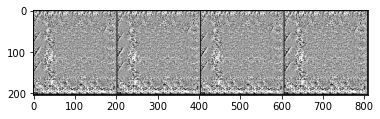

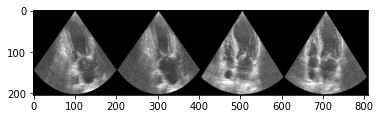

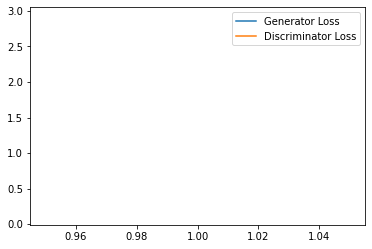


[EPOCH 2/150] | Loss_D: 0.3842 Loss_G: 1.7251


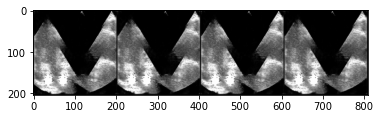

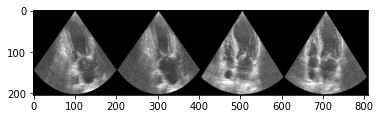

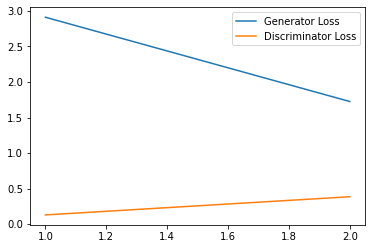


[EPOCH 3/150] | Loss_D: 0.5159 Loss_G: 1.1222


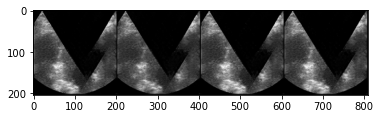

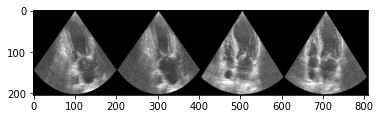

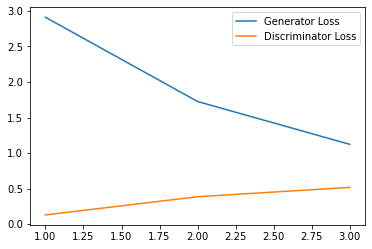


[EPOCH 4/150] | Loss_D: 0.5327 Loss_G: 1.0728


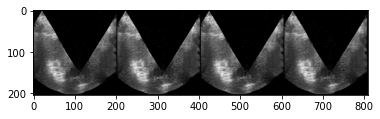

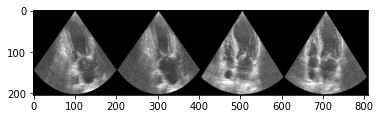

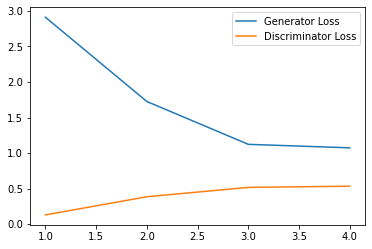


[EPOCH 5/150] | Loss_D: 0.4740 Loss_G: 1.1814


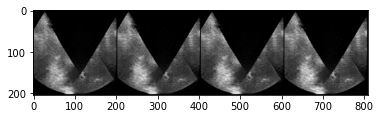

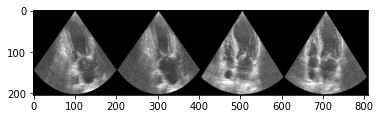

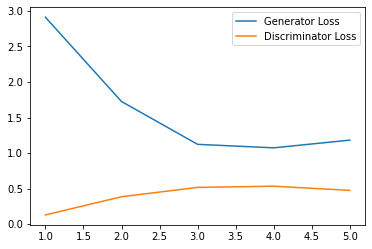


[EPOCH 6/150] | Loss_D: 0.4207 Loss_G: 1.3280


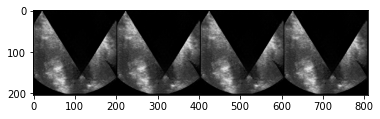

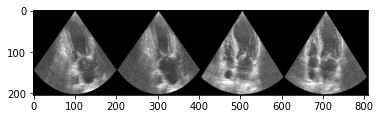

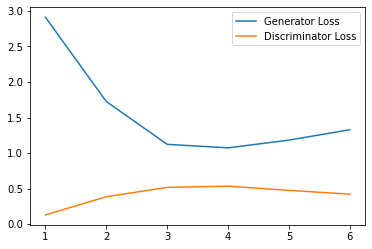


[EPOCH 7/150] | Loss_D: 0.3594 Loss_G: 1.4962


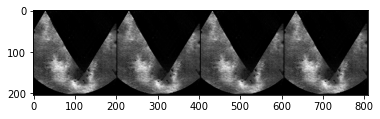

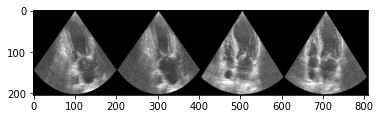

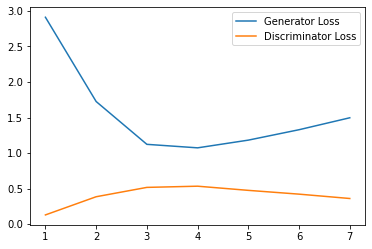


[EPOCH 8/150] | Loss_D: 0.3118 Loss_G: 1.6592


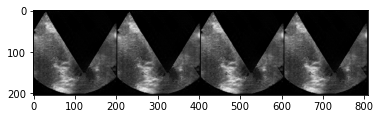

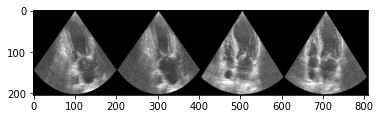

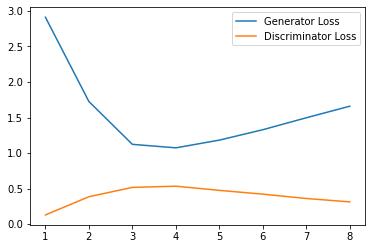


[EPOCH 9/150] | Loss_D: 0.2810 Loss_G: 1.7854


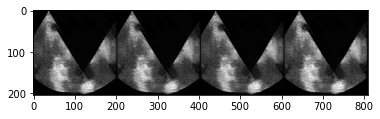

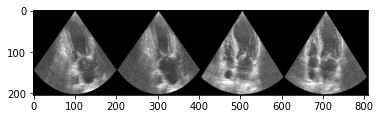

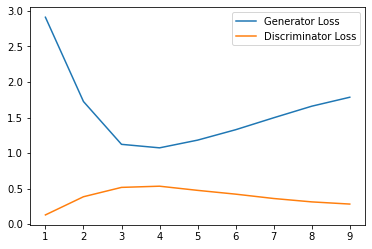


[EPOCH 10/150] | Loss_D: 0.2388 Loss_G: 1.9617


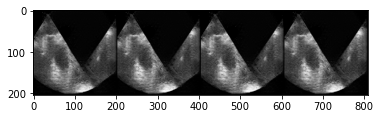

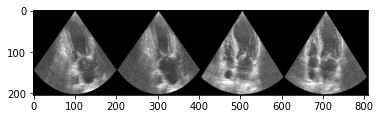

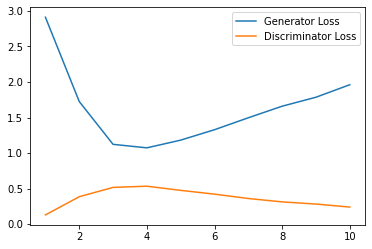


[EPOCH 11/150] | Loss_D: 0.2400 Loss_G: 2.0134


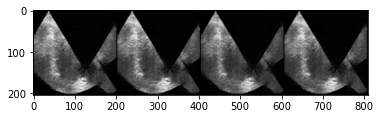

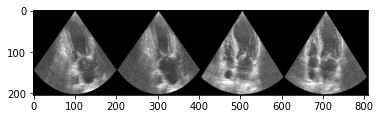

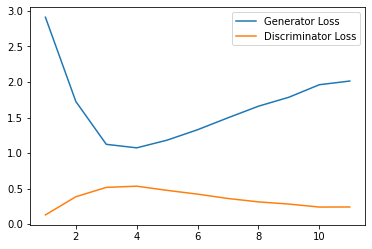


[EPOCH 12/150] | Loss_D: 0.2052 Loss_G: 2.1632


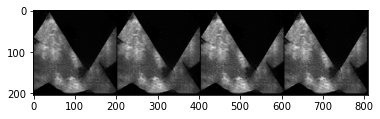

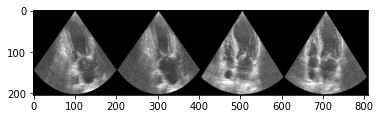

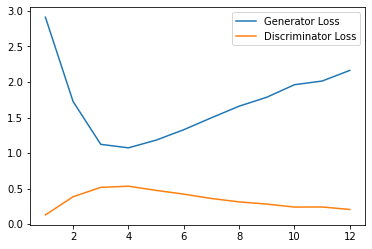


[EPOCH 13/150] | Loss_D: 0.2037 Loss_G: 2.1843


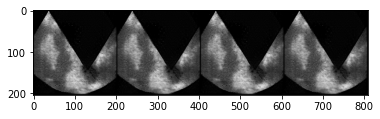

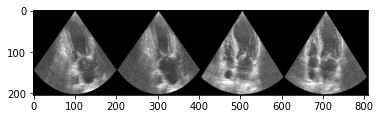

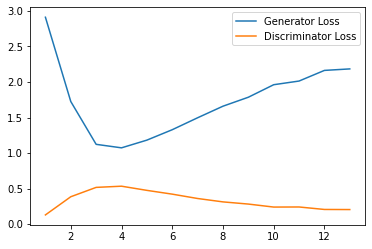


[EPOCH 14/150] | Loss_D: 0.1999 Loss_G: 2.2265


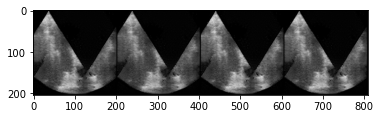

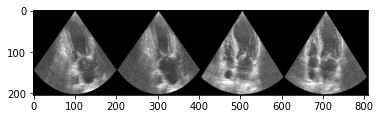

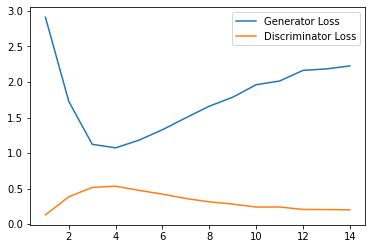


[EPOCH 15/150] | Loss_D: 0.1783 Loss_G: 2.3372


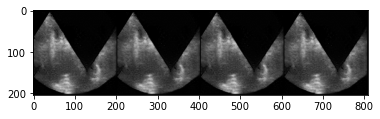

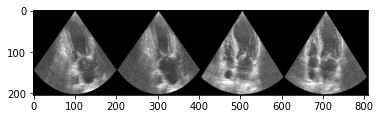

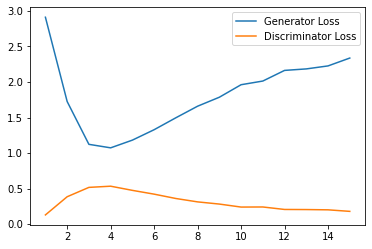


[EPOCH 16/150] | Loss_D: 0.1691 Loss_G: 2.4252


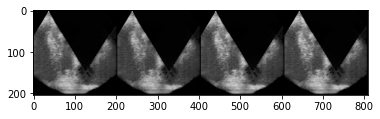

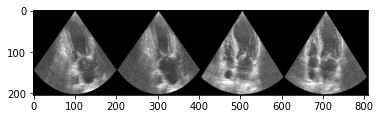

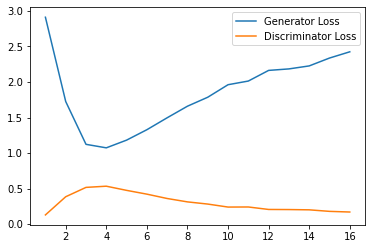


[EPOCH 17/150] | Loss_D: 0.1889 Loss_G: 2.3644


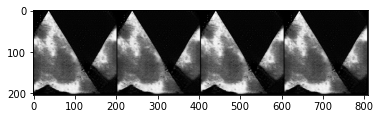

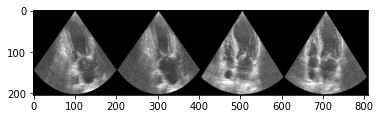

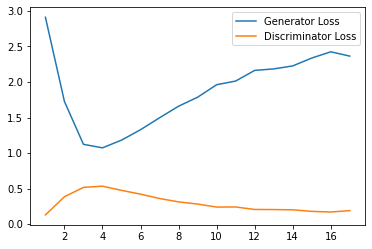


[EPOCH 18/150] | Loss_D: 0.1750 Loss_G: 2.4394


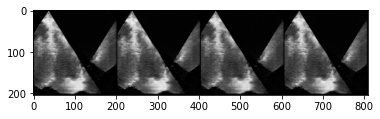

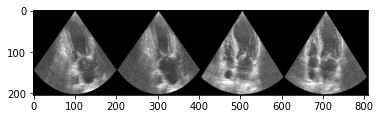

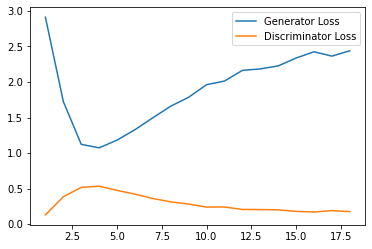


[EPOCH 19/150] | Loss_D: 0.1581 Loss_G: 2.5505


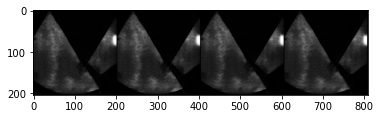

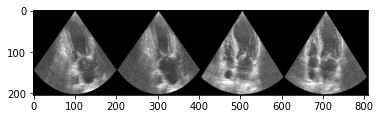

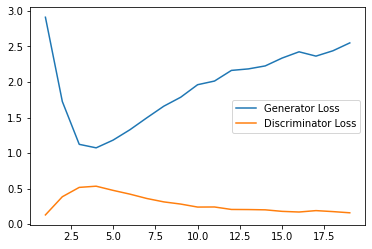


[EPOCH 20/150] | Loss_D: 0.1579 Loss_G: 2.5534


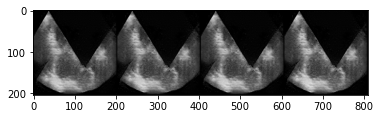

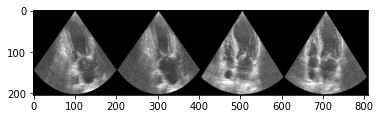

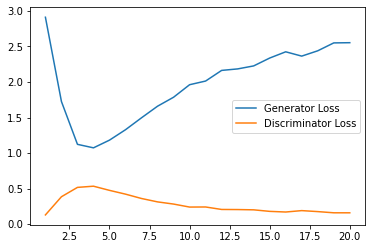


[EPOCH 21/150] | Loss_D: 0.1465 Loss_G: 2.6693


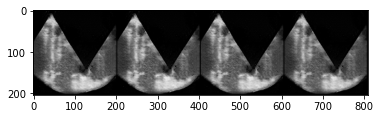

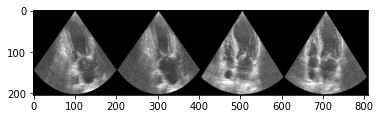

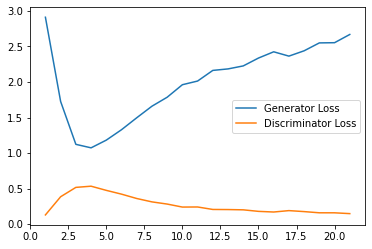


[EPOCH 22/150] | Loss_D: 0.1360 Loss_G: 2.7230


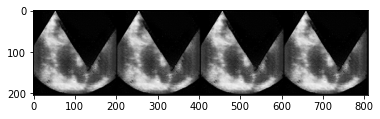

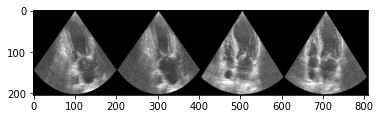

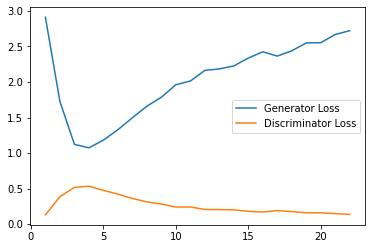


[EPOCH 23/150] | Loss_D: 0.1228 Loss_G: 2.6506


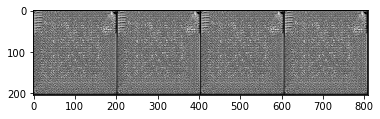

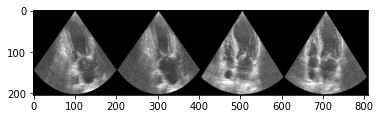

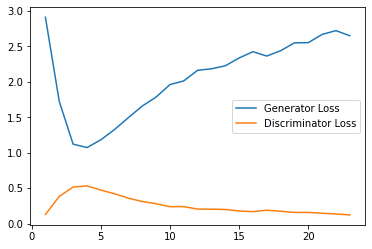


[EPOCH 24/150] | Loss_D: 0.0334 Loss_G: 3.7169


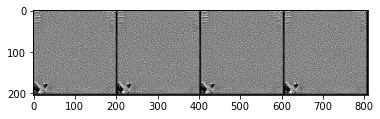

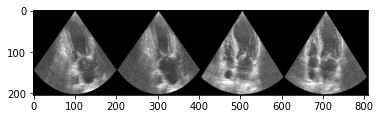

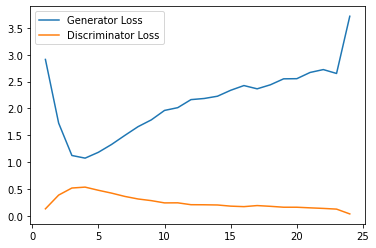


[EPOCH 25/150] | Loss_D: 0.0164 Loss_G: 4.4713


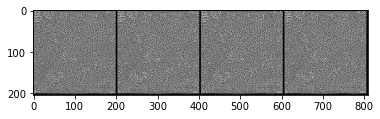

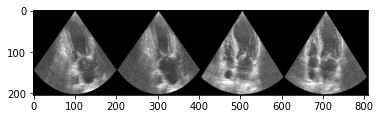

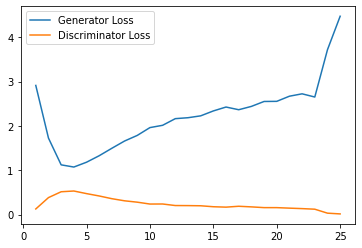


[EPOCH 26/150] | Loss_D: 0.0116 Loss_G: 5.1486


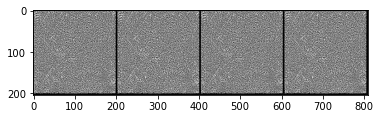

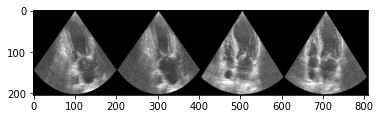

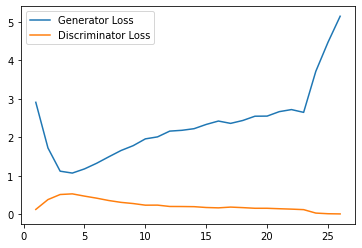


[EPOCH 27/150] | Loss_D: 0.0082 Loss_G: 5.5088


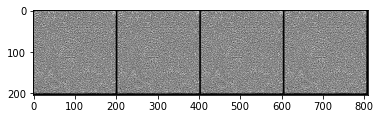

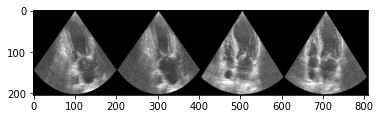

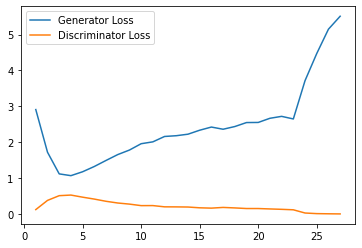


[EPOCH 28/150] | Loss_D: 0.0079 Loss_G: 5.2672


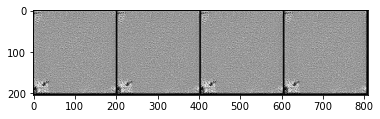

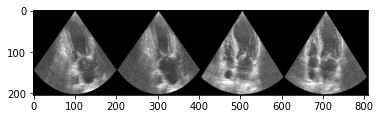

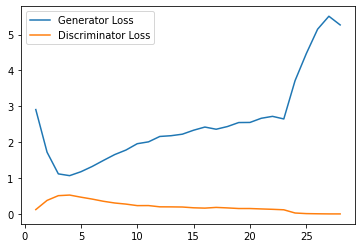


[EPOCH 29/150] | Loss_D: 0.0777 Loss_G: 3.7964


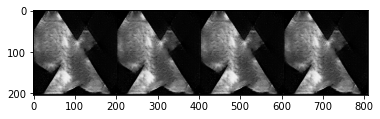

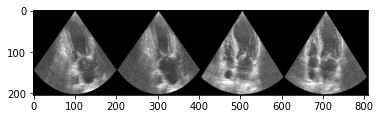

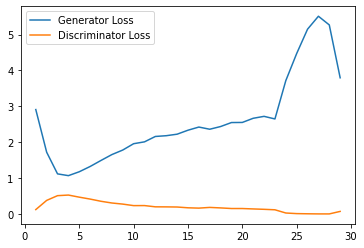


[EPOCH 30/150] | Loss_D: 0.1090 Loss_G: 3.1227


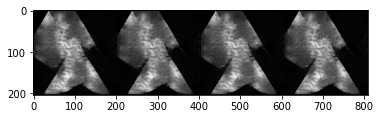

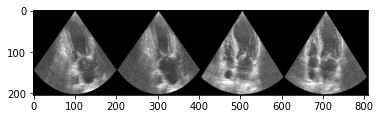

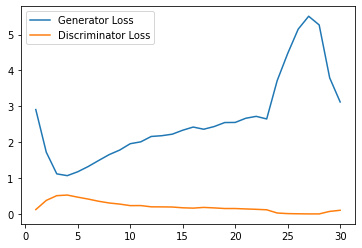


[EPOCH 31/150] | Loss_D: 0.1094 Loss_G: 3.0145


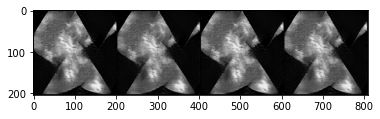

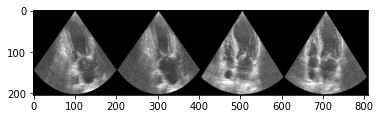

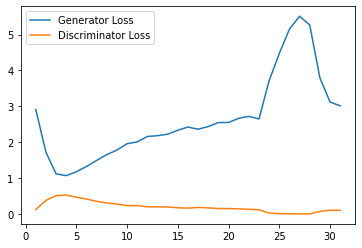


[EPOCH 32/150] | Loss_D: 0.0980 Loss_G: 3.1859


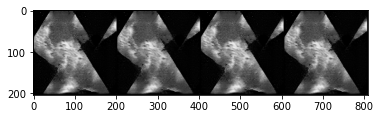

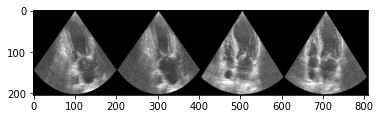

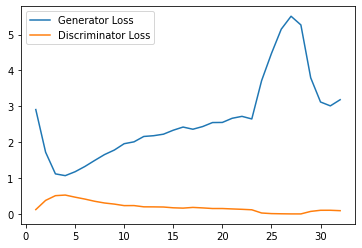


[EPOCH 33/150] | Loss_D: 0.0894 Loss_G: 3.3235


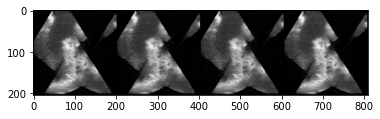

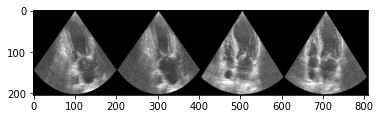

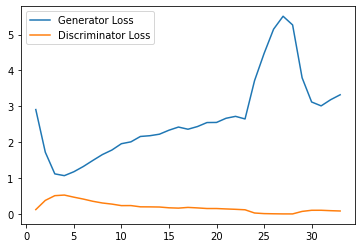


[EPOCH 34/150] | Loss_D: 0.0938 Loss_G: 3.2790


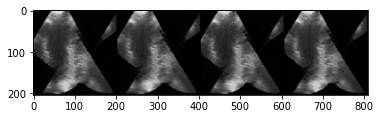

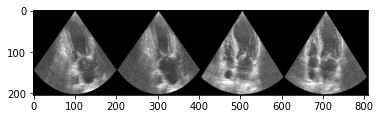

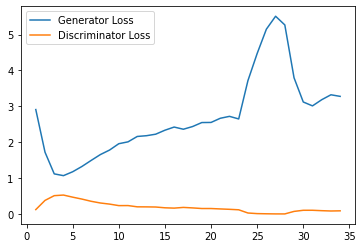


[EPOCH 35/150] | Loss_D: 0.1072 Loss_G: 3.1278


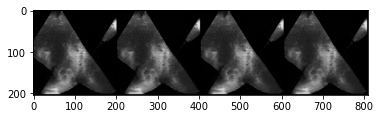

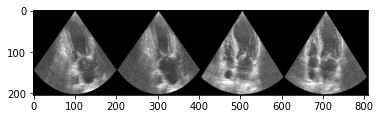

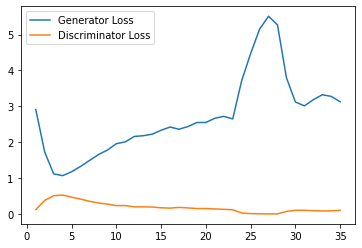


[EPOCH 36/150] | Loss_D: 0.1146 Loss_G: 3.0907


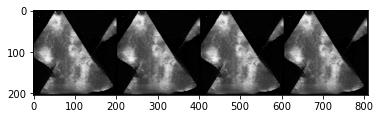

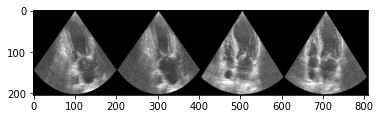

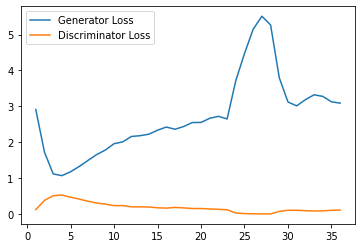


[EPOCH 37/150] | Loss_D: 0.1011 Loss_G: 3.2387


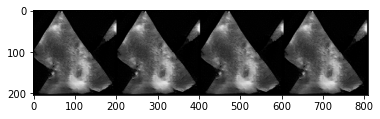

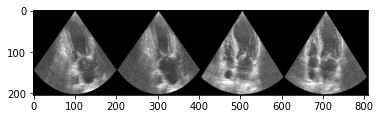

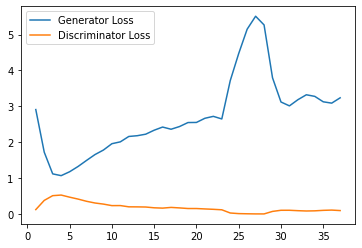


[EPOCH 38/150] | Loss_D: 0.0871 Loss_G: 3.3157


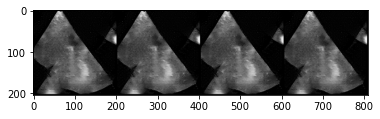

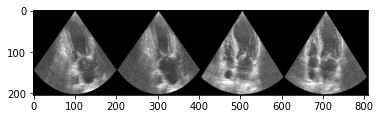

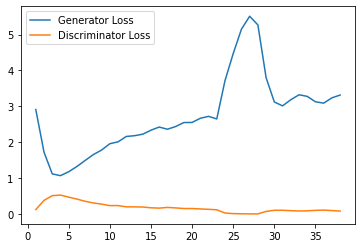


[EPOCH 39/150] | Loss_D: 0.1000 Loss_G: 3.2533


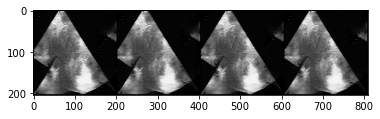

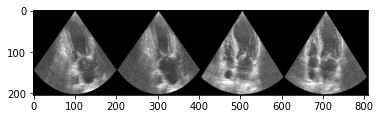

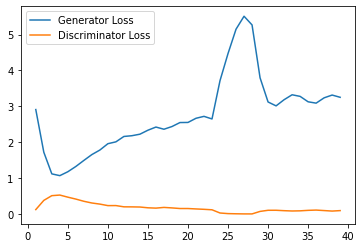


[EPOCH 40/150] | Loss_D: 0.1196 Loss_G: 2.9854


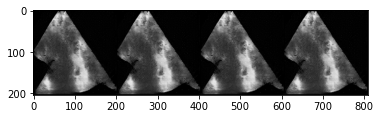

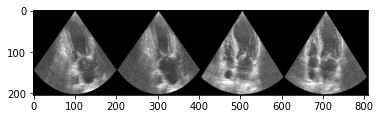

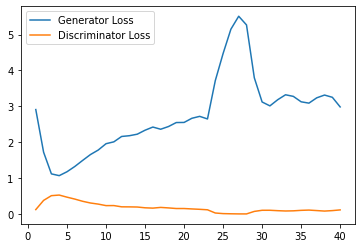


[EPOCH 41/150] | Loss_D: 0.1081 Loss_G: 3.0774


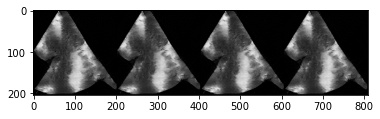

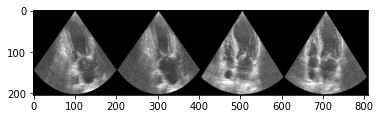

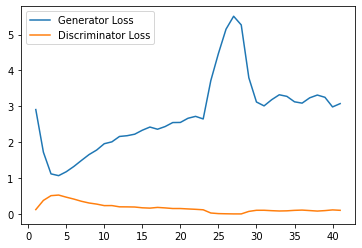


[EPOCH 42/150] | Loss_D: 0.1081 Loss_G: 3.1022


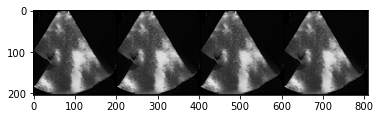

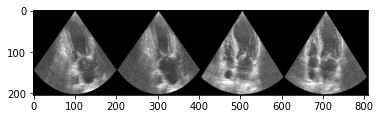

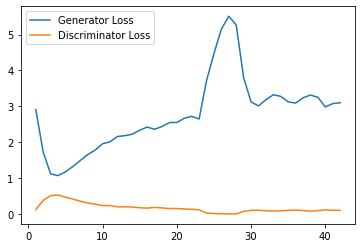


[EPOCH 43/150] | Loss_D: 0.1115 Loss_G: 3.0426


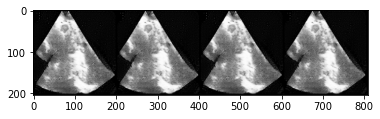

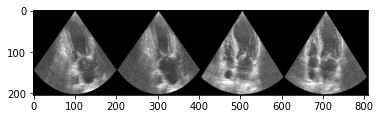

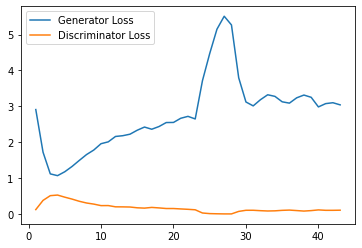


[EPOCH 44/150] | Loss_D: 0.1068 Loss_G: 3.1078


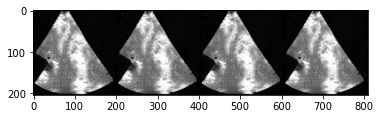

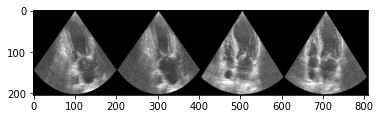

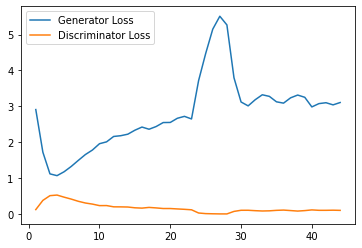


[EPOCH 45/150] | Loss_D: 0.2128 Loss_G: 2.4400


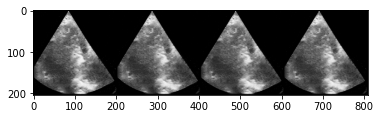

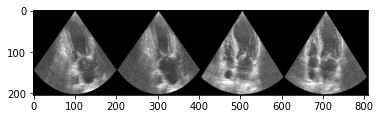

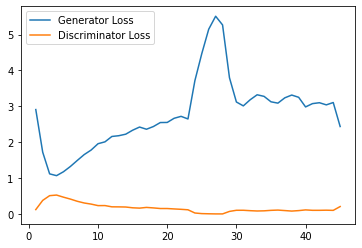


[EPOCH 46/150] | Loss_D: 0.3029 Loss_G: 1.7995


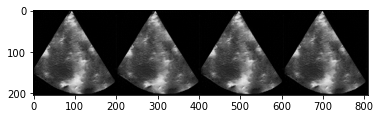

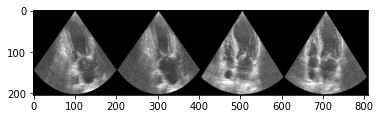

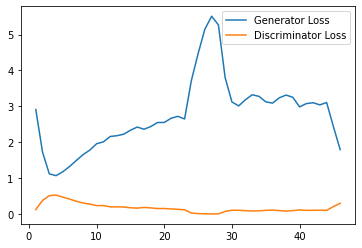


[EPOCH 47/150] | Loss_D: 0.3555 Loss_G: 1.6266


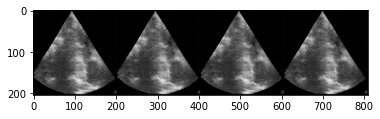

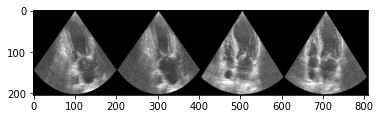

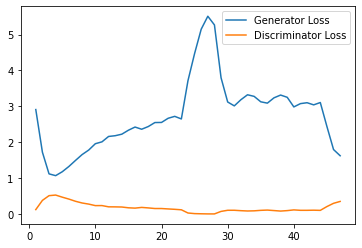


[EPOCH 48/150] | Loss_D: 0.5494 Loss_G: 1.1480


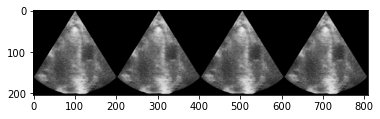

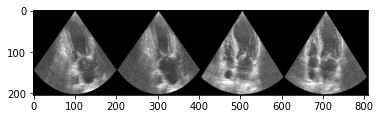

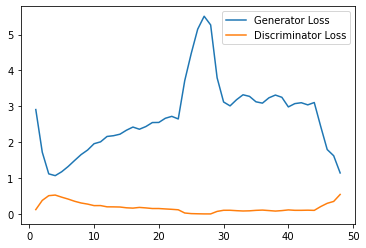


[EPOCH 49/150] | Loss_D: 0.7029 Loss_G: 0.7317


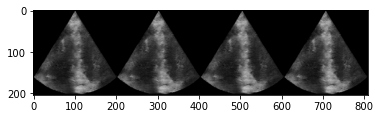

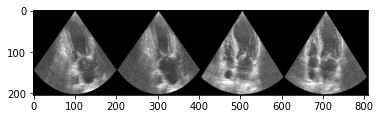

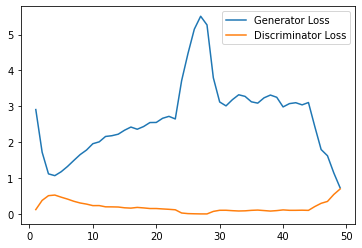


[EPOCH 50/150] | Loss_D: 0.6955 Loss_G: 0.7300


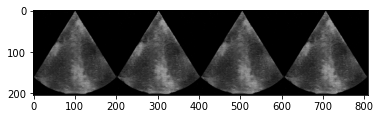

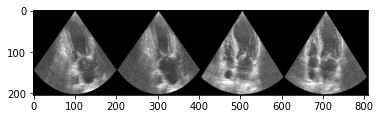

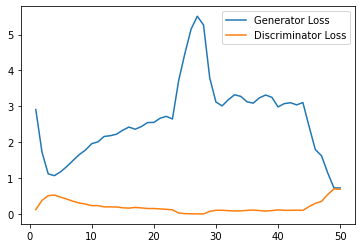


[EPOCH 51/150] | Loss_D: 0.6939 Loss_G: 0.7253


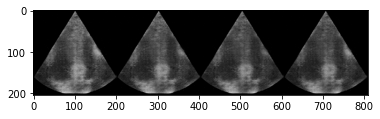

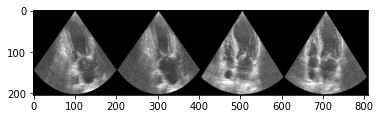

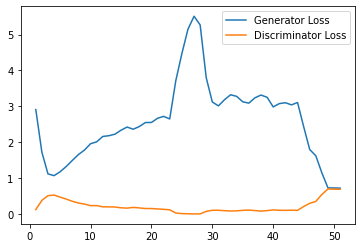


[EPOCH 52/150] | Loss_D: 0.6950 Loss_G: 0.7241


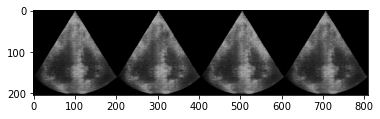

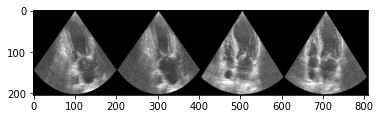

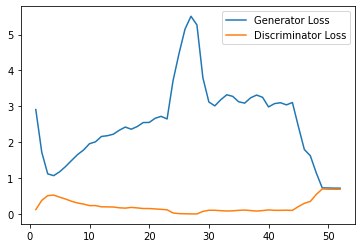


[EPOCH 53/150] | Loss_D: 0.6936 Loss_G: 0.7276


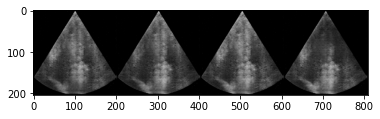

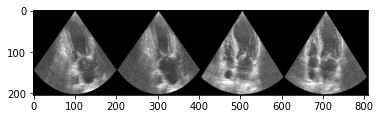

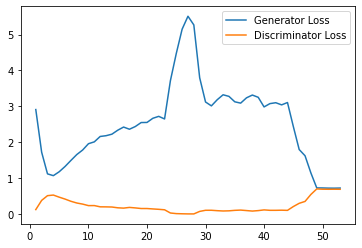


[EPOCH 54/150] | Loss_D: 0.6955 Loss_G: 0.7153


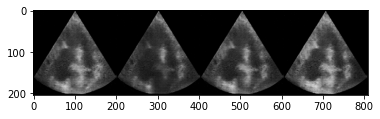

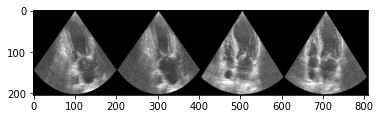

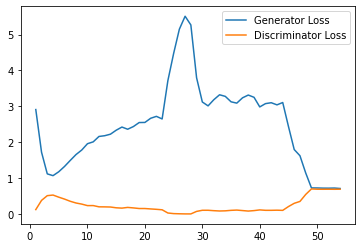


[EPOCH 55/150] | Loss_D: 0.6944 Loss_G: 0.7191


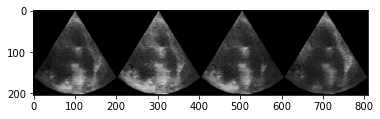

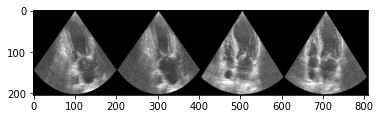

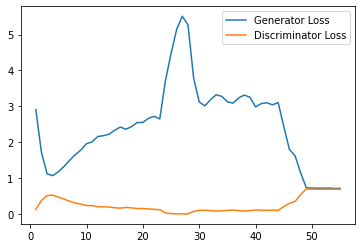


[EPOCH 56/150] | Loss_D: 0.6948 Loss_G: 0.7113


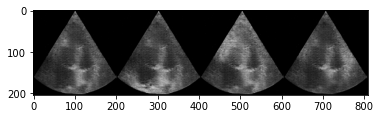

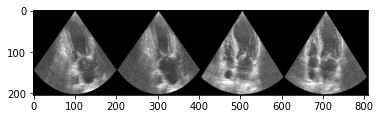

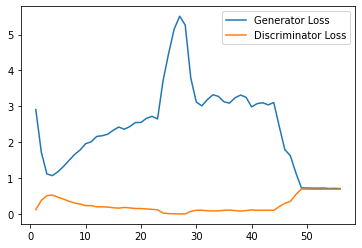


[EPOCH 57/150] | Loss_D: 0.6936 Loss_G: 0.7114


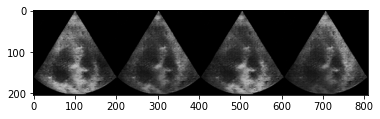

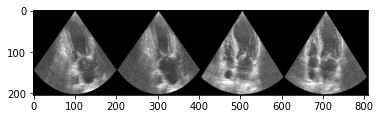

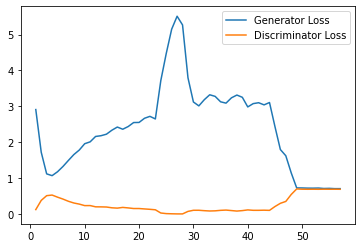


[EPOCH 58/150] | Loss_D: 0.6936 Loss_G: 0.7179


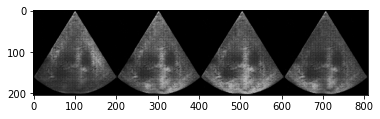

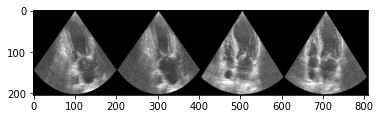

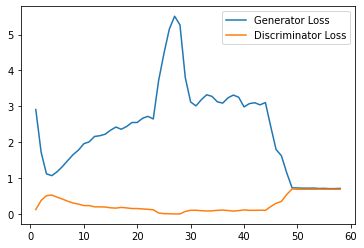


[EPOCH 59/150] | Loss_D: 0.6938 Loss_G: 0.7142


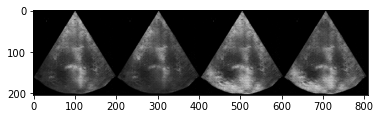

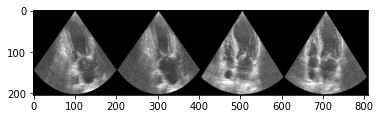

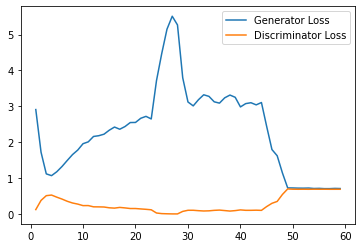


[EPOCH 60/150] | Loss_D: 0.6916 Loss_G: 0.7143


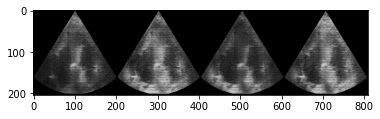

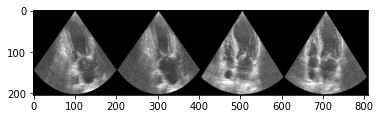

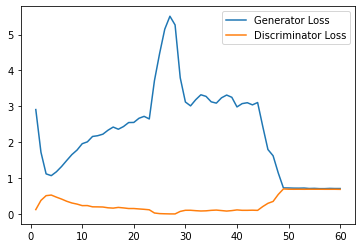


[EPOCH 61/150] | Loss_D: 0.6910 Loss_G: 0.7175


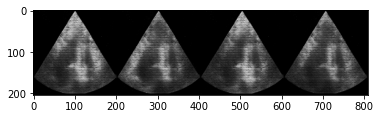

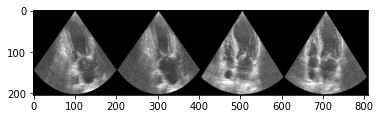

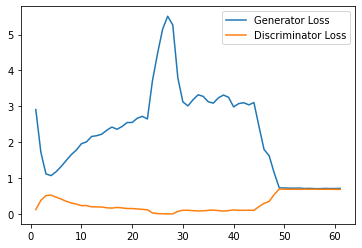


[EPOCH 62/150] | Loss_D: 0.6847 Loss_G: 0.7355


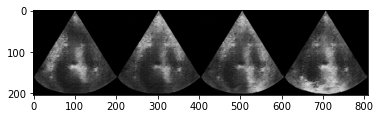

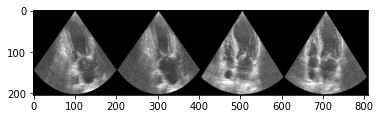

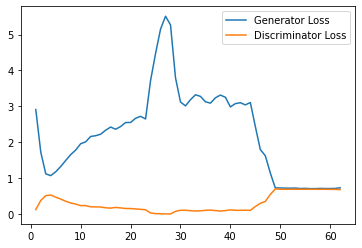


[EPOCH 63/150] | Loss_D: 0.6888 Loss_G: 0.7243


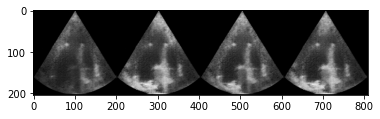

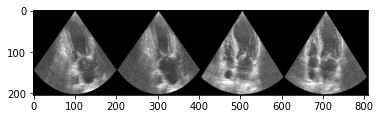

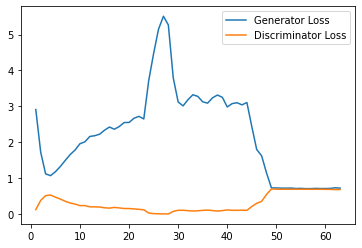


[EPOCH 64/150] | Loss_D: 0.6888 Loss_G: 0.7264


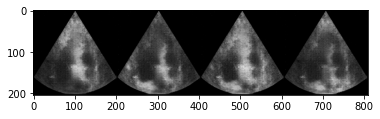

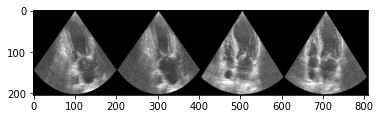

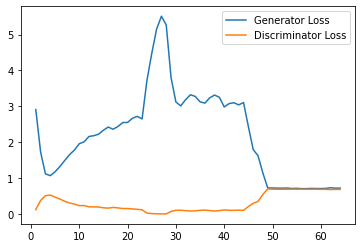


[EPOCH 65/150] | Loss_D: 0.6906 Loss_G: 0.7153


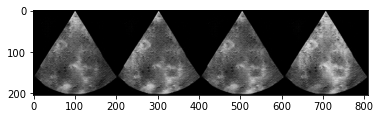

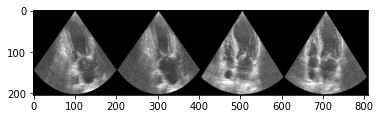

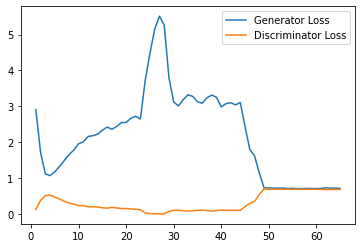


[EPOCH 66/150] | Loss_D: 0.6903 Loss_G: 0.7197


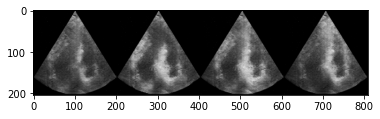

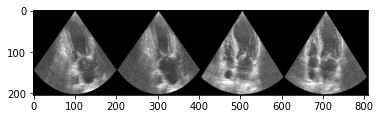

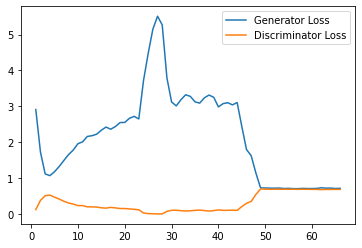


[EPOCH 67/150] | Loss_D: 0.6828 Loss_G: 0.7337


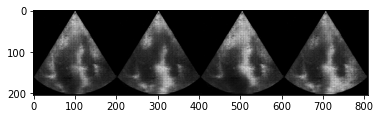

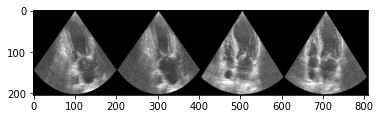

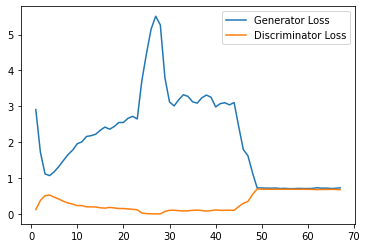


[EPOCH 68/150] | Loss_D: 0.6876 Loss_G: 0.7262


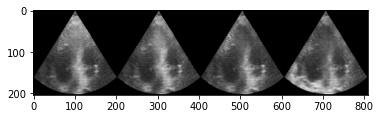

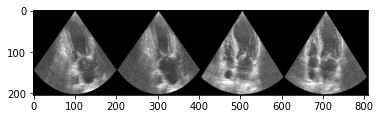

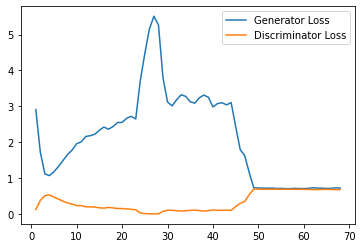


[EPOCH 69/150] | Loss_D: 0.6890 Loss_G: 0.7227


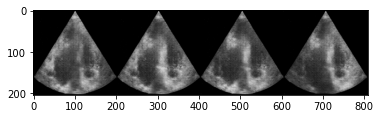

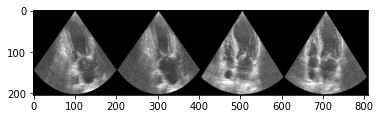

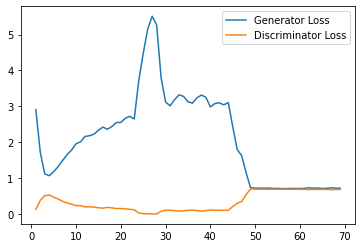


[EPOCH 70/150] | Loss_D: 0.6849 Loss_G: 0.7353


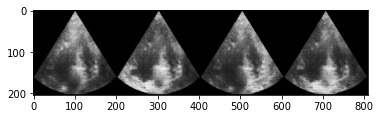

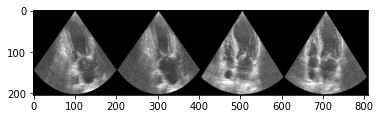

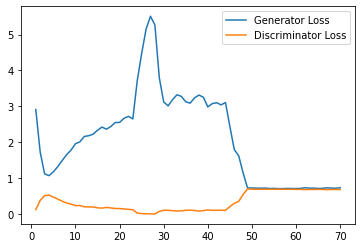

KeyboardInterrupt: 

In [8]:
gen = Generator(z_dim=config["z_dim"]).to(config["device"])
weights_init(gen)
gen_opt = torch.optim.Adam(gen.parameters(), lr=config["gen_lr"], betas=(config["beta_1"], config["beta_2"]))

disc = Discriminator(spectral_norm=config["spectral_norm"]).to(config["device"])
weights_init(disc)
disc_opt = torch.optim.Adam(disc.parameters(), lr=config["disc_lr"], betas=(config["beta_1"], config["beta_2"]))


gen_losses = []
disc_losses = []
for epoch in range(1, config["n_epochs"] + 1):
    epoch_gen_loss = 0
    epoch_disc_loss = 0

    for real in tqdm(dataloader):
        cur_batch_size = len(real)
        real = real.to(config["device"])

        ## Update discriminator ###
        running_disc_loss = 0
        for _ in range(config["disc_repeats"]):
            disc_opt.zero_grad()
            fake = gen(get_noise(cur_batch_size, config["z_dim"], device=config["device"]))
            disc_fake_pred, _ = disc(fake.detach())

            fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))
            fake_loss.backward()

            disc_real_pred, _ = disc(real)
            real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))
            real_loss.backward()

            disc_opt.step()
            
            disc_loss = 0.5 * (real_loss.item() + fake_loss.item())
            running_disc_loss += disc_loss / config["disc_repeats"]        

        epoch_disc_loss += running_disc_loss / len(dataloader)
        
        ### Update generator ###
        running_gen_loss = 0
        for _ in range(config["gen_repeats"]):
            gen_opt.zero_grad()

            fake_2 = gen(get_noise(cur_batch_size, config["z_dim"], device=config["device"]))
            disc_fake_pred, _ = disc(fake_2)

            gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))
            gen_loss.backward()
            gen_opt.step()
            
            running_gen_loss += gen_loss.item() / config["gen_repeats"]

        epoch_gen_loss += running_gen_loss / len(dataloader)
    
    disc_losses += [epoch_disc_loss]
    gen_losses += [epoch_gen_loss]
    
    print(f"[EPOCH {epoch}/{config['n_epochs']}] | Loss_D: {disc_losses[-1]:.4f} Loss_G: {gen_losses[-1]:.4f}")
    show_tensor_images((fake_2 + 1) / 2, size=fake_2.shape[1:])
    show_tensor_images((real + 1) / 2, size=fake_2.shape[1:])
    plt.plot(range(1, len(gen_losses) + 1), gen_losses, label="Generator Loss")
    plt.plot(range(1, len(disc_losses) + 1), disc_losses, label="Discriminator Loss")
    plt.legend(loc="best")
    plt.show()
    
    if epoch % config["epoch_log_step"] == 0:
        save_model(epoch, gen, disc, gen_opt, disc_opt)
        
save_loss(f"{result_folder}/disc_loss.csv", disc_losses)
save_loss(f"{result_folder}/gen_loss.csv", gen_losses)

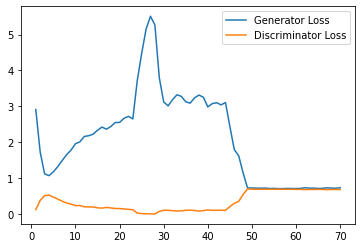

In [9]:
plt.plot(range(1, len(gen_losses) + 1), gen_losses, label="Generator Loss")
plt.plot(range(1, len(disc_losses) + 1), disc_losses, label="Discriminator Loss")
plt.legend(loc="best")
plt.savefig(f"bcloss_loss.pdf", bbox_inches='tight')
plt.show()



In [9]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5)),
    transforms.Resize((200, 200))
    
])
val_dataset = USImagesDataset("camus-images/image", image_transform=transform)
val_dataloader = DataLoader(val_dataset, batch_size=10, num_workers=0)

In [10]:
device = "cuda"
test_gen = Generator(z_dim=config["z_dim"]).to(config["device"]).to(device)
test_gen.load_state_dict(torch.load("./gan-bceloss-02-12-2021-15:54/70.pth")["gan"])
test_gen.eval()

unet_model = UNet(hidden_channels=16).to(config["device"])
unet_model.load_state_dict(torch.load("./unet-results/u-net_79.pth")["unet"])
unet_model.eval()

fake_features_list = []
real_features_list = []
with torch.no_grad():
    for real_example in tqdm(val_dataloader):
        real_samples = real_example.to(device)
        pred, real_features = unet_model(real_samples)
        
        real_features = torch.flatten(real_features.detach().to('cpu'), start_dim=1)
        real_features_list.append(real_features)

        fake_samples = get_noise(len(real_example), config["z_dim"]).to(config["device"])
        fake_samples = test_gen(fake_samples)
        _, fake_features = unet_model(fake_samples.to(config["device"]))
        fake_features = torch.flatten(fake_features.detach().to('cpu'), start_dim=1)
        fake_features_list.append(fake_features)
    
fake_features_all = torch.cat(fake_features_list)
real_features_all = torch.cat(real_features_list)
fid = get_FID(fake_features_all, real_features_all)

In [11]:
print(fid.item())

412.3406677246094


In [14]:
fake_features_all.size()

torch.Size([1800, 1, 5, 5])